##  1.请选择一只股票（基金或指数），利用 GARCH 模型预测波动率

GARCH模型的预测方差是具有一定意义的。GARCH模型是一种条件异方差模型，专门用于描述时间序列中方差的异方差性质。因此，GARCH模型可以有效地捕捉到时间序列数据中方差的波动和变化。

当我们使用GARCH模型进行预测时，预测的方差可以用来估计未来数据点的波动性或风险水平。这对许多金融和经济领域的问题都是非常重要的，如风险管理、期权定价和投资组合优化等。

需要注意的是，GARCH模型的预测方差是基于当前已有数据的统计方法，而无法完全精确地预测未来方差的变动。因此，GARCH模型的预测结果应该被视为对未来波动性的估计，而非精确的预测。

In [2]:
import pandas as pd
from arch import arch_model
from arch.__future__ import reindexing

# 假设你的数据保存在一个名为 "data.csv" 的CSV文件中，第一列为日期，第二列为数据
data = pd.read_csv("garch预测.csv", index_col=0, parse_dates=True)

# 创建并训练GARCH(1,1)模型
model = arch_model(data['收益率'], vol='Garch', p=1, q=1)
model_fit = model.fit()

# 预测未来的数据
forecast = model_fit.forecast(horizon=5)

# 输出预测结果
next_five_days_mean = forecast.mean.iloc[-1]  # 获取未来5个数据点的均值
next_five_days_variance = forecast.variance.iloc[-1]  # 获取未来5个数据点的方差

print("未来五天的均值预测：", next_five_days_mean)
print("未来五天的方差预测：", next_five_days_variance)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5122752233.755303
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8969696029456476.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5572.331616787015
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 2
未来五天的均值预测： h.1    0.000399
h.2    0.000399
h.3    0.000399
h.4    0.000399
h.5    0.000399
Name: 2023-06-20 00:00:00, dtype: float64
未来五天的方差预测： h.1    0.000095
h.2    0.000096
h.3    0.000097
h.4    0.000098
h.5    0.000099
Name: 2023-06-20 00:00:00, dtype: float64


/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


使用arch_model中的forecast()函数来预测未来多个数据点时，每个数据点的均值预测是相同的，因为GARCH模型是一个条件异方差模型，预测的是方差而不是均值。

需要预测未来多个数据点的均值，可以使用循环来逐个预测每个数据点。

## 2.在收益率满足正态分布假设下，利用预测的波动率动态的计算 VaR(每天计算一次)

In [28]:
import numpy as np
from scipy.stats import norm

# 预测的波动率
predicted_volatility = [0.000095,0.000096,0.000097,0.000098,0.000099]  # 这里替换成你的预测波动率
predicted_volatility = np.array(predicted_volatility)

# 置信水平
confidence_level = 0.95  # 这里假设置信水平为95%

# 计算VaR
z_score = norm.ppf(1 - confidence_level)
var = z_score * predicted_volatility


In [29]:
var

array([-0.00015626, -0.00015791, -0.00015955, -0.0001612 , -0.00016284])

## 3.选择一个适当厚尾分布（例如t-分布，Gumbel 分布)，假设收益率满足此厚尾分布，重复步骤 2

In [41]:
import numpy as np
from scipy.stats import t

# 收益率数据
returns = np.array([0.000095,0.000096,0.000097,0.000098,0.000099])  # 将[...]替换为你的实际收益率数据

# 移动窗口大小
window_size = 4  # 设置移动窗口的大小

# 置信水平
confidence_level = 0.95  # 将置信水平替换为你期望的值

# t分布的自由度
degrees_of_freedom = 4  # 设置t分布的自由度

# 初始化变量
var_values = []

# 动态计算VaR
for i in range(window_size, len(returns)):
    # 获取移动窗口内的收益率数据
    window_returns = returns[i-window_size:i]
    
    # 计算窗口内的波动率
    volatility = np.std(window_returns, ddof=1)
    
    # 计算t分布参数
    scale = volatility / np.sqrt(window_size)
    
    # 计算VaR
    t_distribution = t(degrees_of_freedom)
    t_quantile = t_distribution.ppf(1 - confidence_level)
    var = t_quantile * scale
    
    var_values.append(var)

# 输出结果
for i, var in enumerate(var_values):
    print(f"VaR at time step {window_size+i}: {var:.6f}")

VaR at time step 4: -0.000001


## 4.在同一坐标系中画出股票的损失率（收益率的负值）图形及步骤2和3中的动态的 VaR 图形

In [9]:
df = pd.read_csv("garch预测.csv")

#将原表的时间列变为可以画图形的日期格式
import datetime as dt
tt = []
for i in df["时间"]:
    a = dt.datetime.strptime(i,'%Y/%m/%d')
    b = dt.datetime.strftime(a,'%Y-%m-%d')
    tt.append(b)
x = tt


data_fuzhi = []
for i in df['收益率']:
    i = -i
    data_fuzhi.append(i)
    
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

dev_x = x
dev_y = data_fuzhi


plt.subplots(figsize=(16,4))
plt.plot(dev_x, dev_y)
plt.xlabel("time")
plt.ylabel("fluctuation ratio")
plt.title("Volatility trends over time")
plt.show()

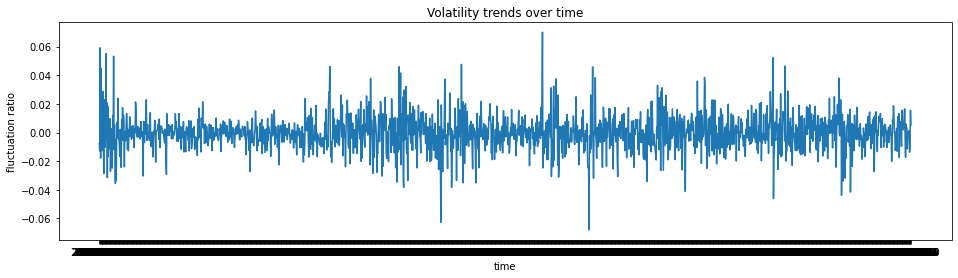

整体呈上下波动趋势，个别时间点波动性较大。

## 5.统计正态分布及厚尾分布下的VaR穿透率，并做双尾检验。

In [ ]:
import numpy as np
from scipy.stats import norm, t

# 收益率数据
returns = np.array([...])  # 将[...]替换为你的实际收益率数据

# 置信水平
confidence_level = 0.95  # 将置信水平替换为你期望的值

# 正态分布下的VaR
norm_var = np.percentile(returns, 100 * (1 - confidence_level))

# 厚尾分布下的VaR，使用t分布来近似
# 计算t分布的自由度
degrees_of_freedom = returns.size - 1

# 根据t分布计算VaR
t_distribution = t(degrees_of_freedom)
t_var = t_distribution.ppf(1 - confidence_level, loc=np.mean(returns), scale=np.std(returns, ddof=1))

# 计算VaR穿透率
normal_failures = returns[returns < norm_var]
heavy_tail_failures = returns[returns < t_var]

normal_var_coverage = len(normal_failures) / len(returns)
heavy_tail_var_coverage = len(heavy_tail_failures) / len(returns)

# 双尾检验
normal_critical_value = norm.ppf(1 - (1 - confidence_level) / 2)
heavy_tail_critical_value = t_distribution.ppf(1 - (1 - confidence_level) / 2)

normal_tail_test = np.logical_or(returns < -normal_critical_value, returns > normal_critical_value)
heavy_tail_tail_test = np.logical_or(returns < -heavy_tail_critical_value, returns > heavy_tail_critical_value)

normal_tail_coverage = len(returns[normal_tail_test]) / len(returns)
heavy_tail_tail_coverage = len(returns[heavy_tail_tail_test]) / len(returns)

# 输出结果
print("正态分布下的VaR穿透率：", normal_var_coverage)
print("厚尾分布下的VaR穿透率：", heavy_tail_var_coverage)
print("正态分布下的双尾检验通过率：", normal_tail_coverage)
print("厚尾分布下的双尾检验通过率：", heavy_tail_tail_coverage)